**Background:**

We are one of the fastest growing startups in the logistics and delivery domain. We work with several partners and make on-demand delivery to our customers. During the COVID-19 pandemic, we are facing several different challenges and everyday we are trying to address these challenges.

We thrive on making our customers happy. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.

Getting feedback from customers is not easy either, but we do our best to get constant feedback from our customers. This is a crucial function to improve our operations across all levels.

We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.

**Data Description:**

**Y** = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers

**X1** = my order was delivered on time

**X2** = contents of my order was as I expected

**X3** = I ordered everything I wanted to order

**X4** = I paid a good price for my order

**X5** = I am satisfied with my courier

**X6** = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

Goal(s):

Predict if a customer is happy or not based on the answers they give to questions asked.

Success Metrics:

Reach 73% accuracy score or above.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

**Load ACME Happiness Survey**

In [2]:
df = pd.read_csv('ACME-HappinessSurvey2020.csv', skiprows=1, names=["happy", "on_time", "contents", "ordered_everything", "good_price", "satisfied", "app_easy"])
df.head()

,happy,on_time,contents,ordered_everything,good_price,satisfied,app_easy
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   happy               126 non-null    int64
 1   on_time             126 non-null    int64
 2   contents            126 non-null    int64
 3   ordered_everything  126 non-null    int64
 4   good_price          126 non-null    int64
 5   satisfied           126 non-null    int64
 6   app_easy            126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
happy,126.0,0.547619,0.499714,0.0,0.0,1.0,1.0,1.0
on_time,126.0,4.333333,0.800000,1.0,4.0,5.0,5.0,5.0
contents,126.0,2.531746,1.114892,1.0,2.0,3.0,3.0,5.0
ordered_everything,126.0,3.309524,1.023440,1.0,3.0,3.0,4.0,5.0
good_price,126.0,3.746032,0.875776,1.0,3.0,4.0,4.0,5.0
satisfied,126.0,3.650794,1.147641,1.0,3.0,4.0,4.0,5.0
app_easy,126.0,4.253968,0.809311,1.0,4.0,4.0,5.0,5.0


**Happiness:** Currently at an average of .54. This could be better and thus validates the necessity of a survey to discover what customers value in order to be happy

**On Time:** Average is at 4.33 out of 5 which is great. Most customers are receiving their packages on time and rate this highly.

**Contents as Expected:** Average of 2.53 out of 5. This is not great and deserves further inspection.

**Ordered Everything:** Average of 3.3 out of 5. Not bad, however not perfect either.

**Good Price:** Average of 3.74 out of 5. Again not bad, and customers seem to on average believe they are getting a good value.

**Satisied with Courier:** Decent average of 3.65 out of 5. Not bad.

**App Easy to Use:** Great Score of 4.25 out of 5. Customers seem to believe that the app is easy to use.

**Visualize Correlation Between Features and Target Variable Y**

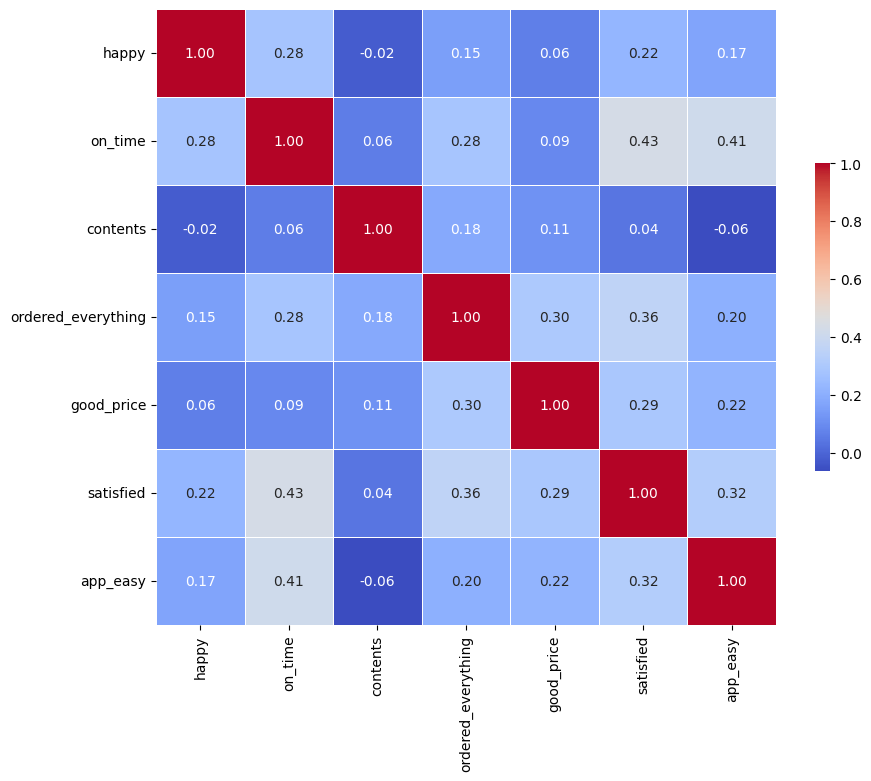

In [5]:
corr = df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

**Plot Each Feature vs Happiness**

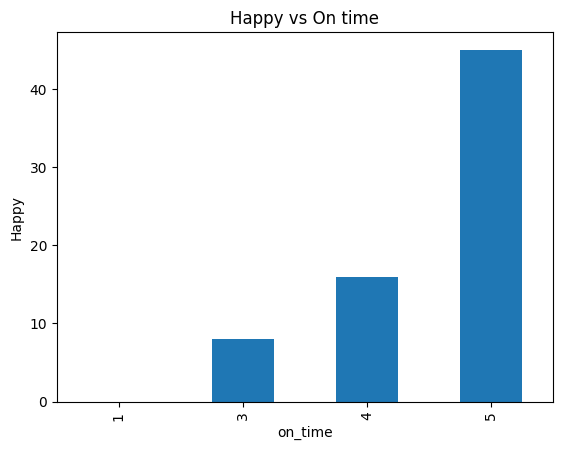

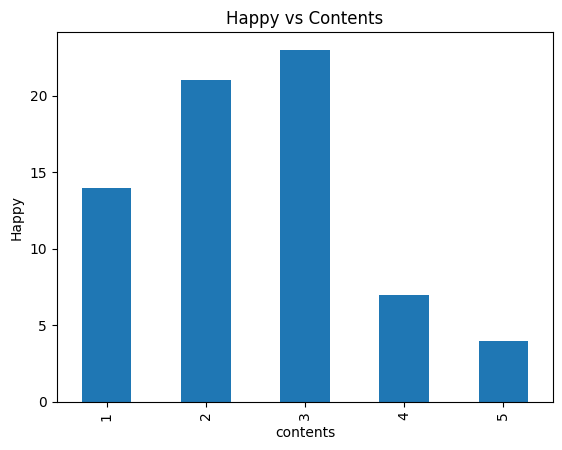

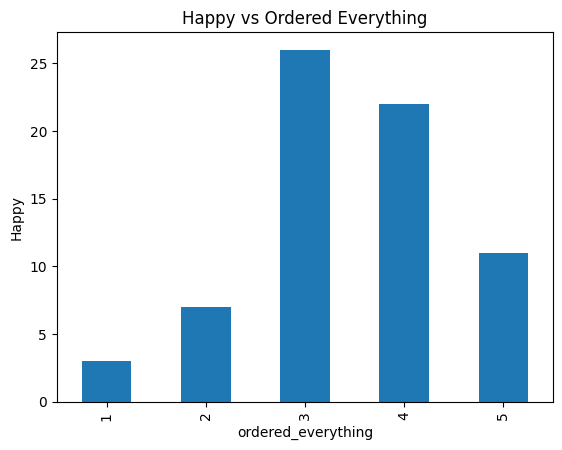

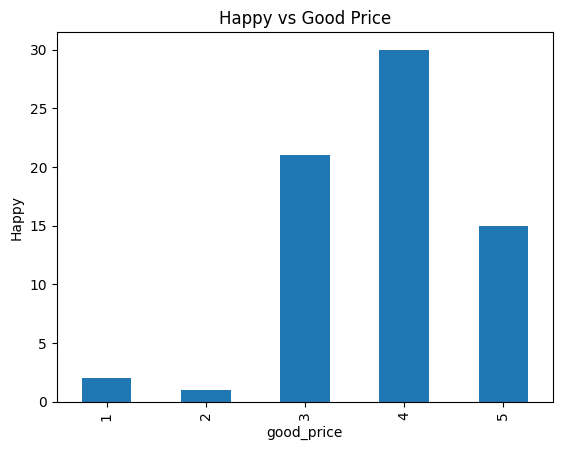

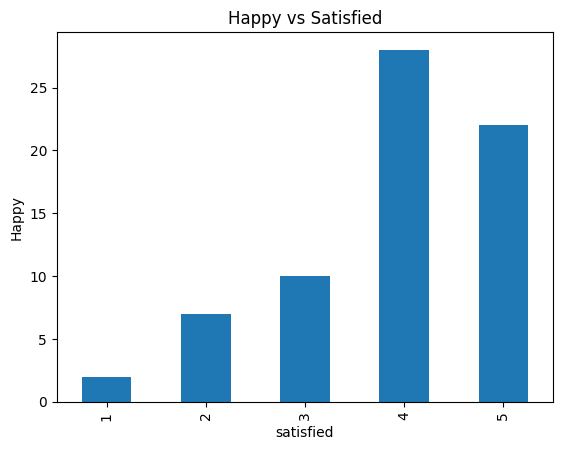

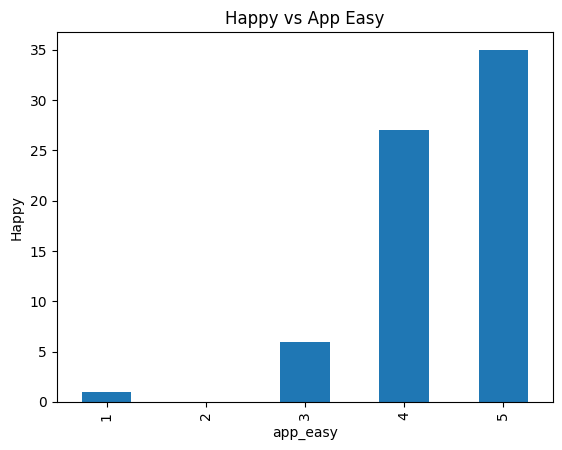

In [6]:
df.groupby('on_time')['happy'].sum().plot(kind='bar')
plt.xlabel('on_time')
plt.ylabel('Happy')
plt.title('Happy vs On time')
plt.show()

df.groupby('contents')['happy'].sum().plot(kind='bar')
plt.xlabel('contents')
plt.ylabel('Happy')
plt.title('Happy vs Contents')
plt.show()

df.groupby('ordered_everything')['happy'].sum().plot(kind='bar')
plt.xlabel('ordered_everything')
plt.ylabel('Happy')
plt.title('Happy vs Ordered Everything')
plt.show()

df.groupby('good_price')['happy'].sum().plot(kind='bar')
plt.xlabel('good_price')
plt.ylabel('Happy')
plt.title('Happy vs Good Price')
plt.show()

df.groupby('satisfied')['happy'].sum().plot(kind='bar')
plt.xlabel('satisfied')
plt.ylabel('Happy')
plt.title('Happy vs Satisfied')
plt.show()

df.groupby('app_easy')['happy'].sum().plot(kind='bar')
plt.xlabel('app_easy')
plt.ylabel('Happy')
plt.title('Happy vs App Easy')
plt.show()

**Preliminary Analysis:**

**On Time:** Seems to have the strongest correlation out of all the features.

**Contents as Expected:** Does **NOT** seem to have any strong relationship to happiness.

**Ordered Everything:** Also does **NOT** seem to have any meaningful relationship to happiness.

**Good Price:** Seems to have a loosely positive correlation to happiness, this is also shown through the correlation matrix.

**Satisfied With Courier:** Has a strong positive linear relationship to happiness.

**App Easy:** Positively correlated to happiness.

**Model Testing:**

**Split Data**

In [7]:
X = df.drop('happy', axis=1)
y = df['happy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Scale the Data with Standard Scalar**

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Logistic Regression:**

In [9]:
lr = LogisticRegression()

lr.fit(X_train_scaled, y_train)

lr_pred = lr.predict(X_test_scaled)

print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.67      0.33      0.44        12
           1       0.60      0.86      0.71        14

    accuracy                           0.62        26
   macro avg       0.63      0.60      0.58        26
weighted avg       0.63      0.62      0.59        26



**Logistic Regression Analysis:**

The Logistic Regression Model Seems to fit decently well, however it still lies below the target 73% accuracy requirement. It's recall on predicting unhappy (0), is particularly low. This means there are a lot of false negatives being predicted by mistake.

**RandomForestClassifier:**

In [10]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train_scaled, y_train)

importance = rf_classifier.feature_importances_

for feature, importance_value in zip(X.columns, importance):
    print(f"{feature}: {importance_value}")

on_time: 0.17609285093031404
contents: 0.1751637689561162
ordered_everything: 0.20565588885761932
good_price: 0.16355469431446007
satisfied: 0.1661266901512882
app_easy: 0.11340610679020224


**Feature Importance Analysis:** According to this default parameter Random Forest Model, the most important feature at predicting happiness is the Ordered Everything feature. This is not expected as the correlation matrix indicates its the third most correlated feature to happiness. This will come in handy when selecting features.

In [11]:
rf_pred = rf_classifier.predict(X_test_scaled)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.73      0.57      0.64        14

    accuracy                           0.65        26
   macro avg       0.66      0.66      0.65        26
weighted avg       0.67      0.65      0.65        26



**RandomForestClassifier Analysis:**

Performs better than the Logistic Regression model with an Accuracy Score of .65. This is Still below our goal of 73%, however both recall and f1-scores are looking better with this model.

**XGBoostClassifier:**

In [12]:
xgb_classifier = xgb.XGBClassifier()

xgb_classifier.fit(X_train_scaled, y_train)

xgb_pred = xgb_classifier.predict(X_test_scaled)

print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.42      0.42      0.42        12
           1       0.50      0.50      0.50        14

    accuracy                           0.46        26
   macro avg       0.46      0.46      0.46        26
weighted avg       0.46      0.46      0.46        26



**XGBoostClassifier Analysis:** 

Worst performing model out of the box with an accuracy score of .46.

**Feature Selection:** 

Out of all the features in the dataset, most do not seem as if they would help predict happiness. For this first round I will remove all features except **on_time** and **satisfied** as they have the most correlation to target variable happy

In [13]:
X = df[['on_time', 'satisfied', 'contents']]
y = df['happy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Retry All models on new smaller feature set:**

In [14]:
lr.fit(X_train_scaled, y_train)
rf_classifier.fit(X_train_scaled, y_train)
xgb_classifier.fit(X_train_scaled, y_train)

lr_pred = lr.predict(X_test_scaled)
rf_pred = rf_classifier.predict(X_test_scaled)
xgb_pred = xgb_classifier.predict(X_test_scaled)
print('Precision Score:', precision_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred))

print('Precision Score:', precision_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

print('Precision Score:', precision_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

Precision Score: 0.6
              precision    recall  f1-score   support

           0       0.67      0.33      0.44        12
           1       0.60      0.86      0.71        14

    accuracy                           0.62        26
   macro avg       0.63      0.60      0.58        26
weighted avg       0.63      0.62      0.59        26

Precision Score: 0.9090909090909091
              precision    recall  f1-score   support

           0       0.73      0.92      0.81        12
           1       0.91      0.71      0.80        14

    accuracy                           0.81        26
   macro avg       0.82      0.82      0.81        26
weighted avg       0.83      0.81      0.81        26

Precision Score: 0.9166666666666666
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       0.92      0.79      0.85        14

    accuracy                           0.85        26
   macro avg       0.85      0.85  

**Model Analysis:** 

All models have improved from before feature selection. However, the Logistic Regression model only made minimal improvements. Whereas both the RandomForestClassifier and XGBoost Classifier have improved tremendously, going past the 73% accuracy Goal.

**Hyperparameter Tuning:**

In [15]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05, None],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2, None]
}
GridSearchCV_xgb = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='accuracy')
GridSearchCV_xgb.fit(X_train_scaled, y_train)
print(GridSearchCV_xgb.best_params_)
print(GridSearchCV_xgb.best_score_)

xgb_pred = GridSearchCV_xgb.predict(X_test_scaled)
print(classification_report(y_test, xgb_pred))

{'gamma': 0, 'learning_rate': None, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100}
0.6699999999999999
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.79      0.79      0.79        14

    accuracy                           0.77        26
   macro avg       0.77      0.77      0.77        26
weighted avg       0.77      0.77      0.77        26



**Conclusion:** We have tried to create three different models to predict whether a customer will be happy with their order or not.

Each model had promising results as the logistic regression model initially seemed like a worthy candidate, however failed to improve with more selective feature selection.

The Random Forest and XGBoost models performed about on par with each other after feature selection with the random forest model producing a .81 accuracy on test data, while the XGBoost model had a .77 accuracy on test data.

Overall, the best performing model was the XGBoost model given that it had a slightly higher accuracy, precision, and recall than the XGBoost model. On all these metrics the XGBoost model performed the best.

However, it is important to note that even the best performing models did not meet the .73 accuracy requirement on test data when cross validated across multiple subsets of the data. This is likely due to the models overfitting slightly.